# We will solve the Simple Harmonic equation here
$$
\frac{d^2 }{dx^2}y(x)+y(x)=0
$$
for the boundary conditions $y(0)=1$ and $y'(0)=1$

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# LEts start by defining the domain in which I want the solution of this differntial equation
random_array = np.random.uniform(low = 0, high = 5, size = 50)
x = torch.tensor(random_array,requires_grad=True)
x = x.float()
print(x)
x_input = x.unsqueeze(dim=1)

x_input.requires_grad_(True)
print(x_input)

tensor([4.6383, 4.5298, 0.4752, 3.4954, 0.6522, 0.0294, 3.8676, 2.8668, 2.7053,
        2.4226, 1.9535, 2.0645, 2.4603, 1.6300, 0.8331, 0.6064, 1.4571, 0.4152,
        1.4406, 4.5115, 2.3954, 2.8549, 1.4749, 2.3120, 1.1718, 3.4141, 1.8085,
        1.0700, 1.9980, 4.5926, 2.2950, 4.1458, 4.3056, 0.8922, 0.0895, 0.4196,
        3.9262, 4.0905, 0.3786, 1.0599, 1.4348, 2.0972, 2.6417, 2.4149, 4.1967,
        4.7922, 0.7808, 0.4434, 0.8382, 1.6320], grad_fn=<ToCopyBackward0>)
tensor([[4.6383],
        [4.5298],
        [0.4752],
        [3.4954],
        [0.6522],
        [0.0294],
        [3.8676],
        [2.8668],
        [2.7053],
        [2.4226],
        [1.9535],
        [2.0645],
        [2.4603],
        [1.6300],
        [0.8331],
        [0.6064],
        [1.4571],
        [0.4152],
        [1.4406],
        [4.5115],
        [2.3954],
        [2.8549],
        [1.4749],
        [2.3120],
        [1.1718],
        [3.4141],
        [1.8085],
        [1.0700],
        [1.9980],
  

## Now I will define neural network and everything else will follow accordingly

In [2]:
class PINN(nn.Module):
    def __init__(self, in_layer = int, out_layer = int, num_of_layer = int, hidden_size = int):
        super().__init__()
        self.input_layer = nn.Linear(in_layer, hidden_size)
        self.activation = nn.Tanh() # For smooth derivatives

        # Creating scalable model
        hidden_layer = []
        for _ in range(num_of_layer-1):
            hidden_layer.append(nn.Linear(in_features = hidden_size, out_features = hidden_size))
            hidden_layer.append(nn.Tanh())
        
        # Registering the list of layers as module list
        self.hidden_stack = nn.ModuleList(hidden_layer)


        #Defining the output layer
        self.output_layer = nn.Linear(hidden_size, out_layer)
    

    #Forward pass
    def forward(self, x: torch.tensor):
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_stack:
            x = layer(x)

        x = self.output_layer(x)
        return x
# 2. Define the Initialization Rule
def xavier_init_rule(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

# Defining a new instance of the model

In [3]:
# Let's see if the code is working
# torch.manual_seed(10)

# Creating an instance of our neural network
my_first_model = PINN(1,1,5,5)

my_first_model.apply(xavier_init_rule)


y_preds = my_first_model(x_input)
print(y_preds)

# my_first_model.state_dict()

tensor([[0.1391],
        [0.1385],
        [0.0451],
        [0.1306],
        [0.0577],
        [0.0031],
        [0.1340],
        [0.1231],
        [0.1208],
        [0.1161],
        [0.1065],
        [0.1090],
        [0.1167],
        [0.0984],
        [0.0683],
        [0.0547],
        [0.0933],
        [0.0403],
        [0.0928],
        [0.1384],
        [0.1156],
        [0.1230],
        [0.0938],
        [0.1140],
        [0.0835],
        [0.1298],
        [0.1031],
        [0.0794],
        [0.1076],
        [0.1389],
        [0.1137],
        [0.1361],
        [0.1372],
        [0.0713],
        [0.0094],
        [0.0406],
        [0.1345],
        [0.1357],
        [0.0372],
        [0.0790],
        [0.0926],
        [0.1097],
        [0.1198],
        [0.1159],
        [0.1364],
        [0.1399],
        [0.0654],
        [0.0426],
        [0.0685],
        [0.0984]], grad_fn=<AddmmBackward0>)


# Boundary condition
Now at this point I am only left with one last ingredient to create the loss function. The boundary conditions. Since, boundary condition of the form
$$
\mathcal{L}_{BC} = ||y_{pred}|_{x=0}-y_{constant}|_{x=0}||^2
$$
This means I need another tensor which is the point x=0

In [4]:
# This is the boundary point
x_bc = torch.tensor(0.0, requires_grad = True).unsqueeze(dim=-1)

# Similarly I need to setup the y point which has a constant value
y_bc = torch.tensor(1.0, requires_grad = False)

# I understand that I need to output the value of network at the pont x_bc which should always be equal to y_bc

# Also I need to specify dy_dx_bc to impose the second boundary condition
dy_dx_bc = torch.tensor(1.0, requires_grad=False)

# y_pred_bc = my_first_model(x_bc)

# Optimizer
I have to choose an optimiser as well

In [5]:
optimizer = torch.optim.AdamW(params=my_first_model.parameters(),lr=0.0001, weight_decay= 0.001)

# ORder of a number

In [6]:
def order(number):
    if number ==0:
        return print("order not defined")
    else :
        order_abs = np.floor(np.log10(abs(number)))
    return order_abs

# Obtainng the learning rate

In [7]:
def lower_learning_rate(order):
    return 10**(order-2)

In [8]:
print(order(.350))
print(lower_learning_rate(order(035.0)))

-1.0
0.1


# Time to train the neural network

In [9]:
# Hyper parameters
epochs = 100000
epoch_count = [0]
loss_track = [1]
pde_loss_track = [0]
boundary_loss_track = [0]
learning_rate=0.001

optimizer = torch.optim.AdamW(params=my_first_model.parameters(),lr= learning_rate, weight_decay= 0.01)

for i in range(epochs):
    # Putting the model in training mode
    my_first_model.train()

    # # Setting the gradients to zero
    # optimizer.zero_grad()

    y_preds = my_first_model(x_input)
    # Calculating the derivative d2y_dx2
    dy_dx = torch.autograd.grad(outputs=y_preds, inputs= x_input, grad_outputs= torch.ones_like(y_preds), create_graph= True)[0]
    # and finally
    d2y_dx2 = torch.autograd.grad(outputs= dy_dx, inputs= x_input, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
    # Caluclating the y at the boundary value

    x_bc = torch.tensor(0.0, requires_grad = True).unsqueeze(dim=-1)
    y_bc = torch.tensor(1.0, requires_grad = False)
    dy_dx_bc = torch.tensor(1.0, requires_grad=False)

    y_pred_bc = my_first_model(x_bc)
    dy_dx_bc_pred = torch.autograd.grad(outputs = y_pred_bc, inputs = x_bc, grad_outputs= torch.ones_like(y_pred_bc), create_graph = True)[0]

    # SO the loss is to be define here then
    loss_diff_eq = torch.mean((d2y_dx2+y_preds)**2) 
    loss_bc_1 = (y_pred_bc-y_bc)**2
    loss_bc_2 = (dy_dx_bc_pred - dy_dx_bc)**2
    boundary_loss = loss_bc_1 + loss_bc_2


    total_loss = 10*loss_diff_eq + 1*(boundary_loss)

    # I am defining learning rate in a special way. The lr will be two order lower than the total_loss

    
    learning_rate = lower_learning_rate(order(total_loss.detach().numpy()[0]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    
    # Setting the gradients to zero
    optimizer.zero_grad()

    # Calculating the backward pass
    total_loss.backward()

    # Updating the model
    optimizer.step()
    
    # epoch_count.append(i)
    # loss_track.append(total_loss.detach().numpy())
    # pde_loss_track.append(loss_diff_eq.detach().numpy())
    # boundary_loss_track.append(boundary_loss.detach().numpy())
    # print(f"Epoch: {i}  | Total loss: {total_loss.detach().numpy()} | Learning rate: {learning_rate}")

    if i%100==0:
        epoch_count.append(i)
        loss_track.append(total_loss.detach().numpy())
        pde_loss_track.append(loss_diff_eq.detach().numpy())
        boundary_loss_track.append(boundary_loss.detach().numpy())
        print(f"Epoch: {i}  | Total loss: {total_loss.detach().numpy()} | Learning rate: {learning_rate}")

Epoch: 0  | Total loss: [1.8892851] | Learning rate: 0.009999999776482582
Epoch: 100  | Total loss: [0.91109324] | Learning rate: 0.0010000000474974513
Epoch: 200  | Total loss: [0.87796474] | Learning rate: 0.0010000000474974513
Epoch: 300  | Total loss: [0.8601246] | Learning rate: 0.0010000000474974513
Epoch: 400  | Total loss: [0.832867] | Learning rate: 0.0010000000474974513
Epoch: 500  | Total loss: [0.7707187] | Learning rate: 0.0010000000474974513
Epoch: 600  | Total loss: [0.10003427] | Learning rate: 0.0010000000474974513
Epoch: 700  | Total loss: [0.05557681] | Learning rate: 9.999999747378752e-05
Epoch: 800  | Total loss: [0.03683791] | Learning rate: 9.999999747378752e-05
Epoch: 900  | Total loss: [0.02525128] | Learning rate: 9.999999747378752e-05
Epoch: 1000  | Total loss: [0.01759593] | Learning rate: 9.999999747378752e-05
Epoch: 1100  | Total loss: [0.0123349] | Learning rate: 9.999999747378752e-05
Epoch: 1200  | Total loss: [0.00984744] | Learning rate: 9.999999747378

In [10]:
validation_points = torch.tensor(np.linspace(0,5,300), requires_grad=False,dtype=torch.float32)
validation_points = validation_points.unsqueeze(dim=1)
print(validation_points)

tensor([[0.0000],
        [0.0167],
        [0.0334],
        [0.0502],
        [0.0669],
        [0.0836],
        [0.1003],
        [0.1171],
        [0.1338],
        [0.1505],
        [0.1672],
        [0.1839],
        [0.2007],
        [0.2174],
        [0.2341],
        [0.2508],
        [0.2676],
        [0.2843],
        [0.3010],
        [0.3177],
        [0.3344],
        [0.3512],
        [0.3679],
        [0.3846],
        [0.4013],
        [0.4181],
        [0.4348],
        [0.4515],
        [0.4682],
        [0.4849],
        [0.5017],
        [0.5184],
        [0.5351],
        [0.5518],
        [0.5686],
        [0.5853],
        [0.6020],
        [0.6187],
        [0.6355],
        [0.6522],
        [0.6689],
        [0.6856],
        [0.7023],
        [0.7191],
        [0.7358],
        [0.7525],
        [0.7692],
        [0.7860],
        [0.8027],
        [0.8194],
        [0.8361],
        [0.8528],
        [0.8696],
        [0.8863],
        [0.9030],
        [0

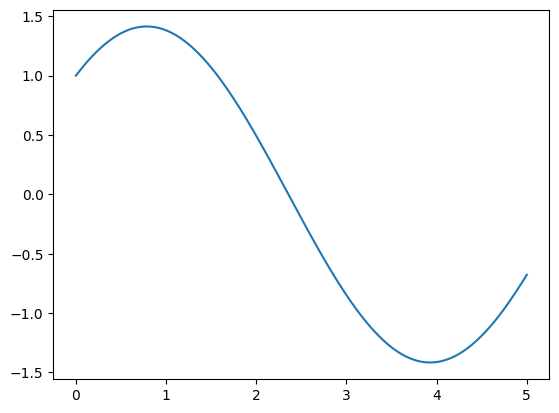

In [11]:
output = my_first_model(validation_points)
plt.plot(validation_points.detach().numpy(),output.detach().numpy())

1001


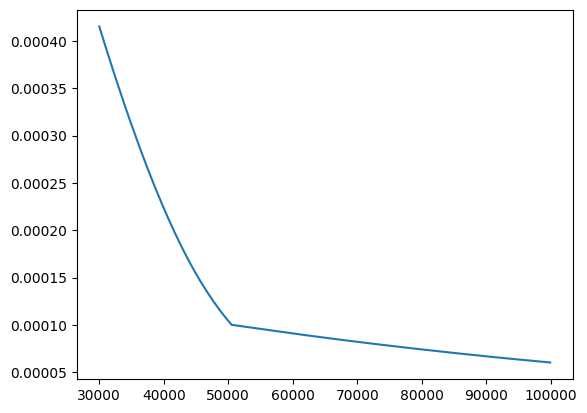

In [12]:
# print(pde_loss_track,epoch_count)
plt.plot(epoch_count[-700:],loss_track[-700:])
# plt.savefig('1_2.png', dpi=300, bbox_inches='tight')
# print(pde_loss_track)
print(len(epoch_count))